### Using Pre-trained CNNs

A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task. 

For instance, you might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it
makes deep learning very effective for small-data problems.

In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to
perform well on the dogs-versus-cats classification problem.

You’ll use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet. This may be your first encounter with one of these cutesy model names—VGG, ResNet, Inception, Inception-ResNet, Xception, and so on; you’ll get used to them, because they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to use a pretrained network:

1. feature extraction and 
2. fine-tuning.


#### 1. Feature Extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As you saw previously, CNNs used for image classification comprise two parts:

they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the convolutional base of the model. In the case of CNNs, feature extraction consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output.

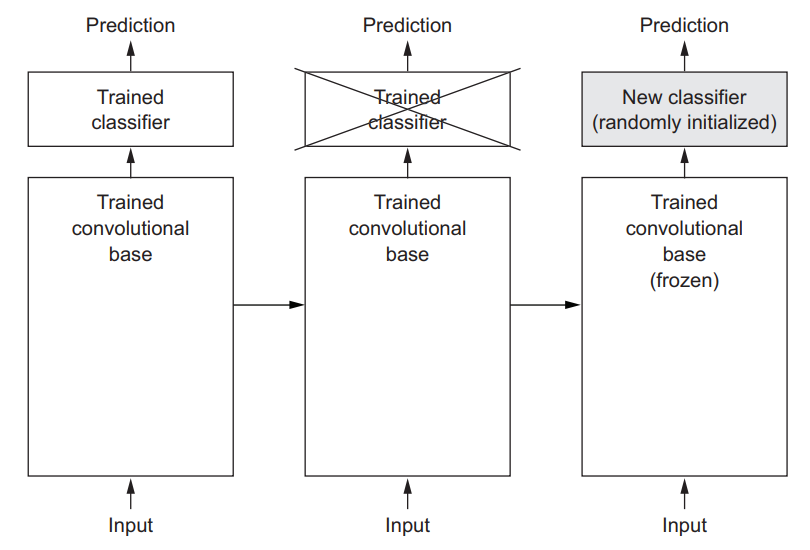

##### Why only reuse the convolutional base? 

Could you reuse the densely connected classifier as well? In general, doing so should be avoided. The reason is that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the feature maps of a CNNs are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer-vision problem at hand. 

But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained—they will only contain information about the presence probability of this or that class in the entire picture. Additionally, representations found in densely connected layers no longer contain any information about where objects are located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature
maps (such as visual edges, colors, and textures), whereas layers that are higher up extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

In this case, because the ImageNet class set contains multiple dog and cat classes, it’s likely to be beneficial to reuse the information contained in the densely connected layers of the original model. But we’ll choose not to, in order to cover the more general case where the class set of the new problem doesn’t overlap the class set of the original model. 

**Let’s put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.**

The VGG16 model, among others, comes prepackaged with Keras. You can import it from the keras.applications module. Here’s the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of keras applications:

* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let’s instantiate the VGG16 model

In [1]:
from keras.applications import VGG16
# from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 202s 3us/step


You pass three arguments to the constructor:
* weights specifies the weight checkpoint from which to initialize the model.
* include_top refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.
* input_shape is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

Here’s the detail of the architecture of the VGG16 convolutional base. It’s similar to the simple convnets you’re already familiar with:


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

The final feature map has shape (4, 4, 512). That’s the feature on top of which you’ll stick a densely connected classifier.

At this point, there are two ways you could proceed:

* Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation 

* Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

We’ll cover both techniques. Let’s walk through the code required to set up the first one: recording the output of conv_base on your data and using these outputs as inputs to a new model

##### Fast Feature Extraction without Data Augmentation

You’ll start by running instances of the previously introduced ImageDataGenerator to extract images as Numpy arrays as well as their labels. You’ll extract features from these images by calling the predict method of the conv_base model.

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) 
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 923ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 954ms/step


The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192)

In [4]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))



In [6]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),loss='binary_crossentropy',metrics=['acc'])


In [7]:
history = model.fit(train_features, train_labels,epochs=30,batch_size=20,validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 17ms/step - loss: 0.6038 - acc: 0.6690 - val_loss: 0.4495 - val_acc: 0.8270
Epoch 2/30
100/100 [==============================] - 2s 15ms/step - loss: 0.4427 - acc: 0.8030 - val_loss: 0.3724 - val_acc: 0.8590
Epoch 3/30
100/100 [==============================] - 2s 15ms/step - loss: 0.3733 - acc: 0.8415 - val_loss: 0.3378 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 2s 16ms/step - loss: 0.3214 - acc: 0.8740 - val_loss: 0.3077 - val_acc: 0.8850
Epoch 5/30
100/100 [==============================] - 1s 15ms/step - loss: 0.2927 - acc: 0.8780 - val_loss: 0.2949 - val_acc: 0.8800
Epoch 6/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2801 - acc: 0.8940 - val_loss: 0.2783 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 2s 15ms/step - loss: 0.2571 - acc: 0.8970 - val_loss: 0.2694 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 2s 16ms/step - 

Training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU.
Let’s look at the loss and accuracy curves during training. 

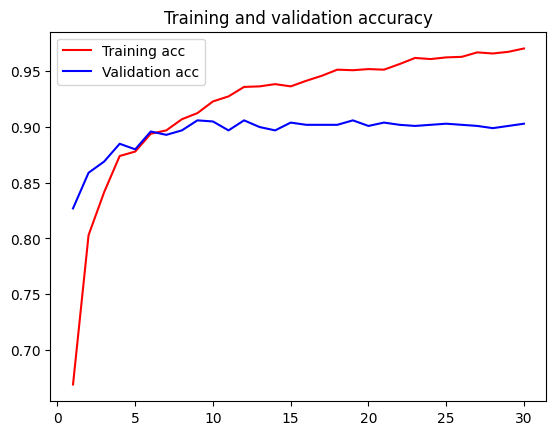

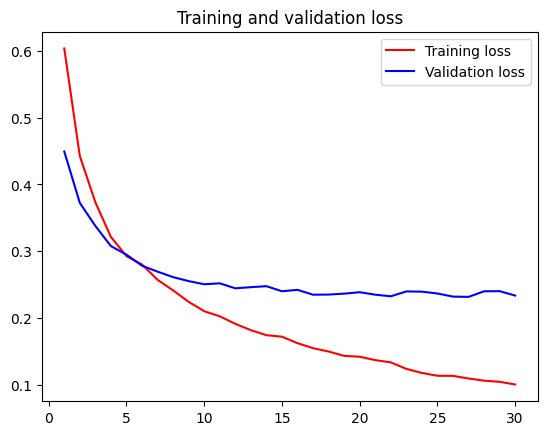

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

You reach a validation accuracy of about 90%—much better than you achieved in the previous section with the small model trained from scratch. But the plots also indicate that you’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets. 

##### Feature Extraction with Data Augmentation

Now, let’s review the second technique mentioned for doing feature extraction, which is much slower and more expensive, but which allows you to use data augmentation during training: extending the conv_base model and running it end to end on
the inputs.

NOTE This technique is so expensive that you should only attempt it if you have access to a GPU—it’s absolutely intractable on CPU. If you can’t run your code on GPU, then the previous technique is the way to go. Because models behave just like layers, you can add a model (like conv_base) to a Sequential model just like you would add a layer.

In [9]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier you’re adding on top has 2 million parameters.

Before you compile and train the model, it’s very important to freeze the convolutional base. **Freezing a layer or set of layers means preventing their weights from being updated during training.** If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a network by setting its trainable attribute to False:

In [11]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that you added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector). 

Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

Now you can start training your model, with the same data-augmentation configuration that you used in the previous example

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])

In [14]:
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/30


C:\Users\laksi\AppData\Local\Temp\ipykernel_7448\2724264653.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 144s 1s/step - loss: 0.5907 - acc: 0.6990 - val_loss: 0.4564 - val_acc: 0.8160
Epoch 2/30
100/100 [==============================] - 156s 2s/step - loss: 0.4824 - acc: 0.7815 - val_loss: 0.3787 - val_acc: 0.8520
Epoch 3/30
100/100 [==============================] - 161s 2s/step - loss: 0.4282 - acc: 0.8200 - val_loss: 0.3403 - val_acc: 0.8620
Epoch 4/30
100/100 [==============================] - 158s 2s/step - loss: 0.3914 - acc: 0.8320 - val_loss: 0.3133 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 162s 2s/step - loss: 0.3825 - acc: 0.8310 - val_loss: 0.2986 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 162s 2s/step - loss: 0.3731 - acc: 0.8330 - val_loss: 0.2872 - val_acc: 0.8830
Epoch 7/30
100/100 [==============================] - 155s 2s/step - loss: 0.3535 - acc: 0.8540 - val_loss: 0.2996 - val_acc: 0.8740
Epoch 8/30
100/100 [==============================] - 154s 2s/step - loss: 0.357

Let’s plot the results again. As you can see, you reach a validation accuracy of about 96%. This is much better than you achieved with the small
convnet trained from scratch

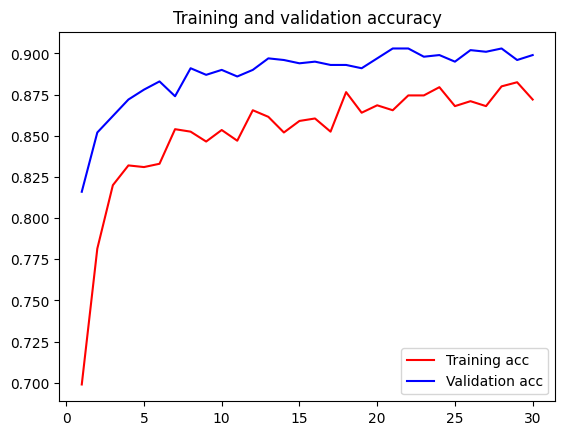

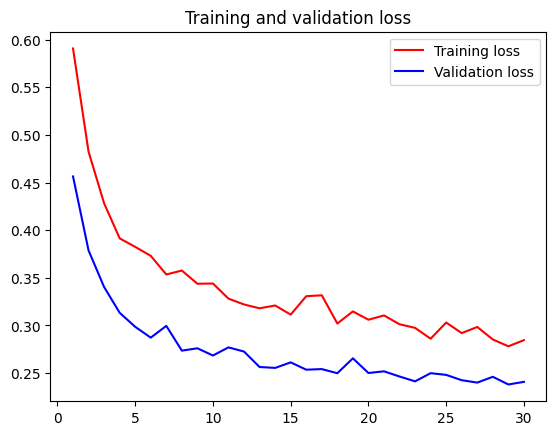

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# code for fine tuning